# Handwritten Comment Extraction from Customer Feedback Forms Using a Custom CRNN-Based OCR Pipeline

## Goal
The goal of this project is to automatically extract handwritten customer comments from physical restaurant feedback forms using a deep learning model, so that the handwritten text can be converted into machine-readable, searchable digital text.

Many restaurants still collect handwritten feedback on paper forms.Reading and digitizing those by hand is slow and error-prone. A deep learning-based OCR (Optical Character Recognition) system can automate this task.

It turns messy human handwriting into clean text that can be:



*  Analyzed for sentiment
*  Stored in a database
*  Used to improve service












## Dataset
We selected the **IAM Handwriting Dataset** as our starting point for the following reasons:

1. **Realistic Handwritten Sentences**  
   - The dataset contains thousands of scanned images of handwritten English sentences written by different individuals.
   - This closely resembles the handwriting variety found in customer feedback forms.

2. **Labeled Ground Truth**  
   - Each image is paired with its corresponding text transcription.
   - This allows us to train our OCR model in a supervised learning setup and evaluate it using standard metrics.

3. **Public Benchmark Dataset**  
   - IAM is widely used in the research community for OCR and handwriting recognition tasks.
   - It provides a strong foundation to build, benchmark, and compare our models.

4. **Useful for Pretraining**  
   - Before fine-tuning on a small set of restaurant feedback forms, pretraining on IAM helps the model learn general handwriting patterns.
   - This improves performance and generalization when we switch to custom data.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/iam_data.zip" -d /content/iam_data/


Streaming output truncated to the last 5000 lines.
  inflating: /content/iam_data/iam_data/lines/h07/h07-025a/h07-025a-01.png  
  inflating: /content/iam_data/iam_data/lines/h07/h07-025a/h07-025a-02.png  
  inflating: /content/iam_data/iam_data/lines/h07/h07-025a/h07-025a-03.png  
  inflating: /content/iam_data/iam_data/lines/h07/h07-025a/h07-025a-04.png  
  inflating: /content/iam_data/iam_data/lines/h07/h07-025a/h07-025a-05.png  
  inflating: /content/iam_data/iam_data/lines/h07/h07-025a/h07-025a-06.png  
  inflating: /content/iam_data/iam_data/lines/h07/h07-025a/h07-025a-07.png  
  inflating: /content/iam_data/iam_data/lines/h07/h07-025a/h07-025a-08.png  
  inflating: /content/iam_data/iam_data/lines/h07/h07-025a/h07-025a-09.png  
   creating: /content/iam_data/iam_data/lines/h07/h07-028/
  inflating: /content/iam_data/iam_data/lines/h07/h07-028/h07-028-00.png  
  inflating: /content/iam_data/iam_data/lines/h07/h07-028/h07-028-01.png  
  inflating: /content/iam_data/iam_data/lines/h

In [ ]:
!mv /content/iam_data/iam_data/* /content/iam_data/
!rm -r /content/iam_data/iam_data


###  Why We Only Used `lines.txt` and the `lines/` Folder

In the IAM dataset, multiple levels of data are provided : words, lines, sentences, and forms.
But for our project, we **only used**:

-  `lines.txt`: contains text transcriptions for each handwritten line
-  `lines/`: contains the corresponding line-level images (e.g., a01-003-01.png)

---

###  Reasons for Using Only These:

1. **Matches Our Project Requirement**
   - Our goal is to extract **entire handwritten comments**, not individual words or characters.
   - Feedback forms contain comments written as full **lines**, not just isolated words.

2. **Cleaner Data Structure**
   - Line-level images are already segmented and aligned with `lines.txt`.
   - No need to manually crop words or forms.

3. **Labeled Text is More Complete**
   - `lines.txt` provides **full sentences** or phrases, this better simulates real customer comments.
   - Word-level data (`words.tgz`) splits things too narrowly (e.g., “M Ps” gets broken).

4. **Easier to Train Sequence Models**
   - Our CRNN model is designed to work on **sequences of characters** (like full sentences), not isolated word images.
   - Using full lines makes the learning task more realistic and meaningful.




In [ ]:
!ls /content/iam_data/


lines  lines.txt


In [ ]:
# a sample of data from the lines.txt
with open('/content/iam_data/lines.txt', 'r', encoding='utf-8') as f:
    count = 0
    for line in f:
        if not line.startswith("#"):
            print(line.strip())
            count += 1
        if count == 10:
            break


a01-000u-00 ok 154 19 408 746 1661 89 A|MOVE|to|stop|Mr.|Gaitskell|from
a01-000u-01 ok 156 19 395 932 1850 105 nominating|any|more|Labour|life|Peers
a01-000u-02 ok 157 16 408 1106 1986 105 is|to|be|made|at|a|meeting|of|Labour
a01-000u-03 err 156 23 430 1290 1883 70 M Ps|tomorrow|.|Mr.|Michael|Foot|has
a01-000u-04 ok 157 20 395 1474 1830 94 put|down|a|resolution|on|the|subject
a01-000u-05 err 156 21 379 1643 1854 88 and|he|is|to|be|backed|by|Mr.|Will
a01-000u-06 ok 159 20 363 1825 2051 87 Griffiths|,|M P|for|Manchester|Exchange|.
a01-000x-00 ok 182 30 375 748 1561 148 A|MOVE|to|stop|Mr.|Gaitskell|from|nominating
a01-000x-01 ok 181 23 382 924 1595 148 any|more|Labour|life|Peers|is|to|be|made|at|a
a01-000x-02 ok 181 30 386 1110 1637 140 meeting|of|Labour|0M Ps|tomorrow|.|Mr.|Michael


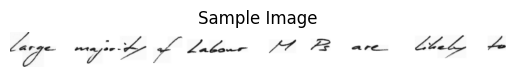

In [ ]:
# a sample image from the lines folder from the iam dataset
import matplotlib.pyplot as plt
import cv2
img_path = "/content/iam_data/lines/a01/a01-003/a01-003-01.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title("Sample Image")
plt.axis('off')
plt.show()


# Data preprocessing on the IAM Dataset

In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset

class IAMLineDataset(Dataset):
    def __init__(self, root_dir, lines_txt, transform=None, max_samples=500):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # so here we are just ignoring all the lines in lines.txt which start with a # , they are the headings
        with open(lines_txt, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith("#"):
                    continue
                # we strip the line by rremoving extra spaces or newline characters
                line = line.strip()
                # split it based on spaces
                parts = line.split(' ')
                # it skips malformed lines in lines.txt that are missing required fields ,
                # So if a line doesn’t have at least 9 parts, it’s not a valid record and cannot be used even if the sentence is short.
                if len(parts) < 9:
                    continue
                # it will extract the unique id and the status of the data sample and skip any samplr which doesnt have ok, we only want clean data
                file_id = parts[0]
                status = parts[1]
                if status != 'ok':
                    continue

                # Extract label text after the 8th space (9 fields)
                split_fields = line.split(' ', 8)
                if len(split_fields) < 9:
                    continue
                label_raw = split_fields[-1]
                transcript = label_raw.replace('|', ' ')

                # Construct image path from file_id , We do this because the images are organized into nested folders,
                # and file_id gives us the structure we need to build the correct path to the image.
                level1 = file_id[:3]
                level2 = file_id[:7]
                img_path = os.path.join(self.root_dir, level1, level2, file_id + '.png')

                # if the image path exists , it justs makes a tuple of the image path and label of that image
                if os.path.exists(img_path):
                    self.samples.append((img_path, transcript))

                if max_samples and len(self.samples) >= max_samples:
                    break
    # returns the total pairs
    def __len__(self):
        return len(self.samples)
    # this will access the image using opencv , resizes it ,normalizes it , converts it into a pytorch tensor and return it with the label
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 32))
        img = img / 255.0
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        return img, label.lower()



In [ ]:
dataset = IAMLineDataset(
    root_dir='/content/iam_data/lines/',
    lines_txt='/content/iam_data/lines.txt',
    max_samples=5
)



Label 0: Though they may gather some Left-wing support , a


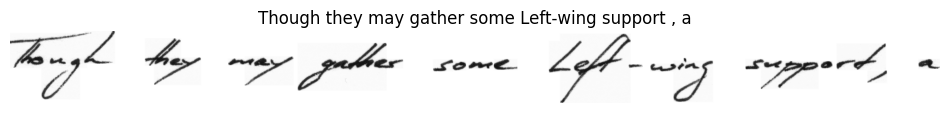

Label 1: large majority of Labour M Ps are likely to


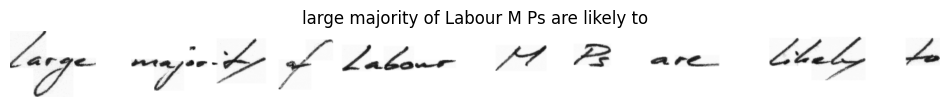

Label 2: turn down the Foot-Griffiths resolution . Mr.


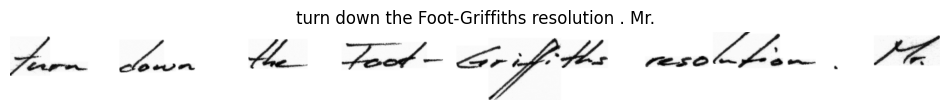

Label 3: Foot's line will be that as Labour M Ps


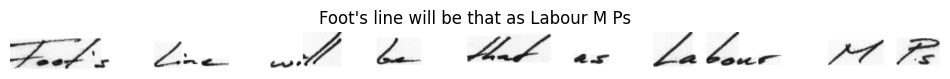

Label 4: opposed the Government Bill which brought


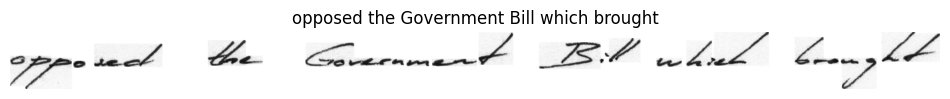

In [ ]:
import matplotlib.pyplot as plt
import cv2

# here we are Showing unresized original images for clarity , fir training these will be resized
for i in range(len(dataset)):
    img_path, label = dataset.samples[i]  # get original path + label
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    print(f"Label {i}: {label}")
    plt.figure(figsize=(12, 4))
    plt.imshow(original_img, cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()


## CRNN MODEL
CRNN = Convolutional + Recurrent + CTC Loss








The CNN helps the model:
“Look at the image and understand basic shapes like lines, curves, and dots ,which form letters.”

*   We start with a grayscale image (shape: [1, 32, 128] = 32 pixels tall, 128 wide), and we want to extract important features from it.
*   nn.Conv2d(1, 64, 3, 1, 1)
➤ Looks at small patches (3x3) of the image
➤ Learns to detect edges, curves, or dots
➤ Converts image from 1 channel (gray) to 64 feature maps (A filtered version of the image that highlights something specific)
One that shows just the vertical lines,
One that shows curves,
One that lights up sharp corners,
One that focuses on dark vs light zones.


*   We use ReLU in CNNs because it’s: Fast ,Simple ,Effective : Helps the network learn sharper and deeper patterns without slowing down.
*  Doesn’t learn anything ; it’s not trainable
Just shrinks the size of the image (downsampling) Keeps only the most important value in each region , It's like: “From each small region, just pick the strongest signal and throw the rest away.”
MaxPool2d(2, 2) means:
➤ “Look at every 2×2 patch of the image,
➤ Keep the maximum value,
➤ Move 2 pixels forward each time.


## CRNN Model Definition (CNN + Bi-GRU + FC)
## The CNN extracts spatial features from handwritten images.
## Features are reshaped and passed through a Bi-GRU to capture sequential dependencies.
## Final fully-connected layer predicts character probabilities per time step.




We designed a Convolutional Recurrent Neural Network (CRNN) architecture in PyTorch to perform handwriting recognition on scanned feedback forms. The model combines:

**CNN Feature Extractor:**

4 convolutional blocks with increasing channel depth (64 → 128 → 256 → 512).

Includes ReLU activations, batch normalization, and max-pooling for spatial compression.

Dropout layers were added after intermediate blocks to reduce overfitting.

Reshaping Layer:

CNN output is reshaped from a 4D tensor to a sequence format (batch × time × features), allowing it to be processed by the RNN.

**Bidirectional GRU:**

A 2-layer Bi-GRU captures dependencies in both forward and backward directions across the character sequence.

Each time step outputs a feature vector summarizing past and future context.

**Normalization + Classifier:**

LayerNorm stabilizes GRU outputs.

A linear layer maps each time step to a probability distribution over possible characters (including the CTC blank token).

This CRNN structure is optimized for handling variable-length handwritten text and enables end-to-end training using CTC loss without requiring character-level alignment during training.



In [ ]:
import torch
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, num_classes):  # passing num_classes from LabelConverter
        super(CRNN, self).__init__()

        # CNN feature extractor
        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),  #  Dropout added

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),
            nn.Dropout(0.4),  #  Dropout added

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),
        )


        self.rnn = nn.GRU(
            input_size=1024,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=0.4  #  Dropout added
        )
        self.norm = nn.LayerNorm(512)  # Normalize GRU output


        # Final classifier (for each time step)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Input: x → [B, 1, 32, 128]
        x = self.cnn(x)  # → [B, 512, 2, 32]

        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2)         # → [B, 32, 512, 2]
        x = x.contiguous().view(b, w, c * h)  # → [B, 32, 1024]

        x, _ = self.rnn(x)               # → [B, 32, 512]
        x = self.norm(x)
        x = self.fc(x)                   # → [B, 32, num_classes]
        return x


 Vocab Encoding + Converter Class

## LabelConverter for character-level encoding and decoding.
## Encodes text labels into index tensors for CTC loss.
## Decodes CTC outputs into readable strings by collapsing repeats and removing blanks.


In [ ]:
import string
import torch

class LabelConverter:
    def __init__(self):
        #  Reduced useful charset
        self.charset = "abcdefghijklmnopqrstuvwxyz .,!?'"

        self.char_to_idx = {char: idx + 1 for idx, char in enumerate(self.charset)}
        self.char_to_idx['<BLANK>'] = 0

        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.num_classes = len(self.char_to_idx)

    def encode(self, text_list):
        """
        Converts a list of strings into a single tensor of character indices,
        plus a tensor of sequence lengths (for CTC loss).
        """
        encoded = []
        lengths = []
        text_list = [t.lower() for t in text_list]

        for text in text_list:
            label = [self.char_to_idx[char] for char in text if char in self.char_to_idx]
            encoded.extend(label)
            lengths.append(len(label))

        return torch.tensor(encoded, dtype=torch.long), torch.tensor(lengths, dtype=torch.long)

    def decode(self, preds):
        """
        Converts CTC output indices back into readable text.
        Input shape: [T, B]
        Output: list of strings
        """
        pred_texts = []
        for pred in preds.permute(1, 0):  # [B, T]
            string = ''
            prev = -1
            for idx in pred:
                idx = idx.item()
                if idx != self.char_to_idx['<BLANK>'] and idx != prev:
                    string += self.idx_to_char.get(idx, '')
                prev = idx
            pred_texts.append(string)
        return pred_texts


In [ ]:
converter = LabelConverter()


In [ ]:
print("Charset:", converter.charset)
print("Blank idx:", converter.char_to_idx['<BLANK>'])
print("Total classes:", converter.num_classes)


Charset: abcdefghijklmnopqrstuvwxyz .,!?'
Blank idx: 0
Total classes: 33


In [ ]:
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Custom collate function for DataLoader
## Stacks image tensors and encodes text labels using the LabelConverter.
## Prepares target tensors and lengths for CTC loss.


In [ ]:
def custom_collate(batch):
    images, texts = zip(*batch)

    images = torch.stack(images)

    targets, target_lengths = converter.encode(texts)

    return images, targets, target_lengths, texts


## Load and split IAM dataset into training and validation sets (80/20).
## Use custom collate function to prepare batches for CTC loss.
## Set up DataLoaders with batching and shuffling.


In [ ]:
from torch.utils.data import DataLoader, random_split

# Load full IAM dataset
full_dataset = IAMLineDataset(
    root_dir='/content/iam_data/lines',
    lines_txt='/content/iam_data/lines.txt',
    max_samples=None  # Load ALL lines
)

# 80/20 train-validation split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=custom_collate
)


In [ ]:
# from google.colab import files
# uploaded = files.upload()  # upload rest_review_dataset.zip

# model = CRNN(num_classes=converter.num_classes)
# model.load_state_dict(torch.load("/content/crnn_trained_final_iam.pth"))
# model = model.to(device)
# model.eval()


Saving crnn_trained_final_iam.pth to crnn_trained_final_iam.pth


CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.25, inplace=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## Train and validate CRNN using CTC loss.
## Logs average losses per epoch and applies learning rate decay every 10 epochs.
## Uses GPU if available.


In [ ]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs = 20  # or more

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, targets, target_lengths, _ in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        images = images.to(device)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)

        logits = model(images)
        log_probs = logits.log_softmax(2)
        input_lengths = torch.full(
            size=(logits.size(0),),
            fill_value=logits.size(1),
            dtype=torch.long,
            device=device
        )

        loss = ctc_loss(log_probs.permute(1, 0, 2), targets, input_lengths, target_lengths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    #  Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets, target_lengths, _ in val_loader:
            images = images.to(device)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)

            logits = model(images)
            log_probs = logits.log_softmax(2)
            input_lengths = torch.full(
                size=(logits.size(0),),
                fill_value=logits.size(1),
                dtype=torch.long,
                device=device
            )

            loss = ctc_loss(log_probs.permute(1, 0, 2), targets, input_lengths, target_lengths)
            val_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    #  Log losses
    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] — Train Loss: {avg_train:.4f} — Val Loss: {avg_val:.4f}")


[Epoch 1] Training: 100%|██████████| 441/441 [00:13<00:00, 31.82it/s]


Epoch [1/20] — Train Loss: 0.2763 — Val Loss: 0.2323


[Epoch 2] Training: 100%|██████████| 441/441 [00:13<00:00, 32.17it/s]


Epoch [2/20] — Train Loss: 0.2626 — Val Loss: 0.2325


[Epoch 3] Training: 100%|██████████| 441/441 [00:13<00:00, 31.81it/s]


Epoch [3/20] — Train Loss: 0.2602 — Val Loss: 0.2446


[Epoch 4] Training: 100%|██████████| 441/441 [00:13<00:00, 32.12it/s]


Epoch [4/20] — Train Loss: 0.2559 — Val Loss: 0.2333


[Epoch 5] Training: 100%|██████████| 441/441 [00:13<00:00, 31.80it/s]


Epoch [5/20] — Train Loss: 0.2525 — Val Loss: 0.2352


[Epoch 6] Training: 100%|██████████| 441/441 [00:13<00:00, 31.95it/s]


Epoch [6/20] — Train Loss: 0.2503 — Val Loss: 0.2321


[Epoch 7] Training: 100%|██████████| 441/441 [00:13<00:00, 31.83it/s]


Epoch [7/20] — Train Loss: 0.2454 — Val Loss: 0.2339


[Epoch 8] Training: 100%|██████████| 441/441 [00:13<00:00, 31.99it/s]


Epoch [8/20] — Train Loss: 0.2433 — Val Loss: 0.2281


[Epoch 9] Training: 100%|██████████| 441/441 [00:13<00:00, 31.94it/s]


Epoch [9/20] — Train Loss: 0.2394 — Val Loss: 0.2389


[Epoch 10] Training: 100%|██████████| 441/441 [00:13<00:00, 31.81it/s]


Epoch [10/20] — Train Loss: 0.2366 — Val Loss: 0.2321


[Epoch 11] Training: 100%|██████████| 441/441 [00:13<00:00, 32.02it/s]


Epoch [11/20] — Train Loss: 0.2248 — Val Loss: 0.2242


[Epoch 12] Training: 100%|██████████| 441/441 [00:13<00:00, 31.71it/s]


Epoch [12/20] — Train Loss: 0.2183 — Val Loss: 0.2234


[Epoch 13] Training: 100%|██████████| 441/441 [00:13<00:00, 32.03it/s]


Epoch [13/20] — Train Loss: 0.2159 — Val Loss: 0.2231


[Epoch 14] Training: 100%|██████████| 441/441 [00:13<00:00, 32.00it/s]


Epoch [14/20] — Train Loss: 0.2118 — Val Loss: 0.2253


[Epoch 15] Training: 100%|██████████| 441/441 [00:13<00:00, 31.73it/s]


Epoch [15/20] — Train Loss: 0.2075 — Val Loss: 0.2255


[Epoch 16] Training: 100%|██████████| 441/441 [00:13<00:00, 32.04it/s]


Epoch [16/20] — Train Loss: 0.2041 — Val Loss: 0.2245


[Epoch 17] Training: 100%|██████████| 441/441 [00:13<00:00, 31.85it/s]


Epoch [17/20] — Train Loss: 0.2021 — Val Loss: 0.2240


[Epoch 18] Training: 100%|██████████| 441/441 [00:13<00:00, 32.20it/s]


Epoch [18/20] — Train Loss: 0.1987 — Val Loss: 0.2273


[Epoch 19] Training: 100%|██████████| 441/441 [00:13<00:00, 31.74it/s]


Epoch [19/20] — Train Loss: 0.1954 — Val Loss: 0.2292


[Epoch 20] Training: 100%|██████████| 441/441 [00:13<00:00, 31.87it/s]


Epoch [20/20] — Train Loss: 0.1919 — Val Loss: 0.2274


In [ ]:
print("Logits shape:", logits.shape)  # Should be [B, T, C]


Logits shape: torch.Size([4, 32, 70])


In [ ]:
torch.save(model.state_dict(), "/content/crnn_trained_final_iam.pth")
from google.colab import files
files.download("/content/crnn_trained_final_iam.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install pyctcdecode


DECODER

In [ ]:
# # Reload your trained IAM model
# model = CRNN(num_classes=converter.num_classes)
# model.load_state_dict(torch.load("/content/crnn_trained_final_iam.pth"))
# model = model.to(device)
# model.eval()

# Load a batch from IAM val_loader
images, _, _, raw_texts = next(iter(val_loader))
images = images.to(device)

# Get model predictions
with torch.no_grad():
    logits = model(images)
    log_probs = logits.log_softmax(2)


In [ ]:
!pip install jiwer


## Evaluate model on IAM validation set using greedy decoding.
## Compare predictions against ground truth using CER and WER.
## Display a few decoded samples for qualitative inspection.


Greedy decoding

In [ ]:
# Greedy decoding
preds = log_probs.argmax(2)         # [B, T]
preds = preds.permute(1, 0)         # [T, B]
decoded_texts_greedy = converter.decode(preds)

# Display predictions
print("----- GREEDY DECODING -----")
for i in range(5):
    print(f"GT   : {raw_texts[i]}")
    print(f"PRED : {decoded_texts_greedy[i]}")
    print("-" * 40)

# CER/WER
from jiwer import cer, wer
print("Greedy CER:", cer(list(raw_texts[:5]), list(decoded_texts_greedy[:5])))
print("Greedy WER:", wer(list(raw_texts[:5]), list(decoded_texts_greedy[:5])))


----- GREEDY DECODING -----
GT   : robbers , or being whisked off to emergency
PRED : mhlo an ti y tle of hirgony
----------------------------------------
GT   : that blonde was something . " " anybody
PRED : thn hae ae o mon tpal,
----------------------------------------
GT   : when only 20 per cent of them stood to gain
PRED : wha agy pernet ther wl ege
----------------------------------------
GT   : everything to his need of inspiration . henze
PRED : mighiy in ad thermnin hie
----------------------------------------
GT   : nuclear weapons in britain . britain then
PRED : wate apoi filt frion the
----------------------------------------
Greedy CER: 0.6682464454976303
Greedy WER: 1.0


## Custom CTC beam search decoder implementation (beam width = 10).
## Decodes log probabilities from CRNN output using path scoring.
## Reduces character repetition and explores alternate decoding paths.


In [ ]:
from collections import defaultdict
import numpy as np

def ctc_beam_search_decoder(log_probs, beam_width=10, blank=0, idx_to_char=None):
    T, C = log_probs.shape
    log_probs = log_probs.cpu().numpy()

    beams = [(tuple(), 0.0)]
    for t in range(T):
        new_beams = defaultdict(lambda: -np.inf)
        for prefix, score in beams:
            for c in range(C):
                p = log_probs[t, c]
                new_prefix = prefix if c == blank else prefix + (c,)
                new_beams[new_prefix] = np.logaddexp(new_beams[new_prefix], score + p)
        beams = sorted(new_beams.items(), key=lambda x: x[1], reverse=True)[:beam_width]

    best_seq = beams[0][0]
    final = []
    prev = None
    for idx in best_seq:
        if idx != blank and idx != prev:
            char = idx_to_char.get(idx, '') if idx_to_char else str(idx)
            final.append(char)
        prev = idx
    return ''.join(final)


In [ ]:
# Beam search decoding
decoded_texts_beam = []
for lp in log_probs:
    decoded = ctc_beam_search_decoder(lp, beam_width=10, idx_to_char=converter.idx_to_char)
    decoded_texts_beam.append(decoded.lower())

# Display predictions
print("----- BEAM SEARCH DECODING -----")
for i in range(5):
    print(f"GT   : {raw_texts[i]}")
    print(f"PRED : {decoded_texts_beam[i]}")
    print("-" * 40)
print("Beam CER:", cer(list(raw_texts[:5]), list(decoded_texts_beam[:5])))
print("Beam WER:", wer(list(raw_texts[:5]), list(decoded_texts_beam[:5])))



----- BEAM SEARCH DECODING -----
GT   : robbers , or being whisked off to emergency
PRED : mhlo an ti y tle of hirgony
----------------------------------------
GT   : that blonde was something . " " anybody
PRED : thn hae ae o mon tpal,
----------------------------------------
GT   : when only 20 per cent of them stood to gain
PRED : wha agy pernet ther wl ege
----------------------------------------
GT   : everything to his need of inspiration . henze
PRED : mighiy in ad thermnin hie
----------------------------------------
GT   : nuclear weapons in britain . britain then
PRED : wate apoi filt frion the
----------------------------------------
Beam CER: 0.6682464454976303
Beam WER: 1.0


RESTAURANT REVIEW DATASET


## Custom Dataset class for restaurant feedback images.
## Loads grayscale images and corresponding text from a CSV file.
## Normalizes text and resizes images to CRNN input size.


In [ ]:
from google.colab import files
uploaded = files.upload()  # upload rest_review_dataset.zip


Saving rest_review_dataset.zip to rest_review_dataset (1).zip


In [ ]:
!unzip rest_review_dataset.zip -d /content/rest_review_dataset/


Archive:  rest_review_dataset.zip
   creating: /content/rest_review_dataset/rest_review_dataset/
  inflating: /content/rest_review_dataset/rest_review_dataset/rev_comment_001.png  
  inflating: /content/rest_review_dataset/rest_review_dataset/rev_comment_002.png  
  inflating: /content/rest_review_dataset/rest_review_dataset/rev_comment_003.png  
  inflating: /content/rest_review_dataset/rest_review_dataset/rev_comment_004.png  
  inflating: /content/rest_review_dataset/rest_review_dataset/rev_comment_005.png  
  inflating: /content/rest_review_dataset/rest_review_dataset/rev_comment_006.png  
  inflating: /content/rest_review_dataset/rest_review_dataset/rev_comment_007.png  
  inflating: /content/rest_review_dataset/rest_review_dataset/rev_comment_008.png  
  inflating: /content/rest_review_dataset/rest_review_dataset/rev_comment_009.png  
  inflating: /content/rest_review_dataset/rest_review_dataset/rev_comment_010.png  
  inflating: /content/rest_review_dataset/rest_review_dataset/r

In [ ]:
uploaded = files.upload()


Saving ground_truth_label.csv to ground_truth_label.csv


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import cv2
from torch.utils.data import DataLoader

class RestaurantReviewDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.data['filename'] = self.data['filename'].apply(lambda x: x + '.png')  # Add .png
        self.data['text'] = self.data['text'].str.lower()  # Normalize
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        label = row['text']

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.resize(img, (128, 32))
        img = img / 255.0
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # [1, 32, 128]

        return img, label


## Load restaurant review dataset and prepare DataLoader.
## Uses same collate function and batch format as IAM dataset for consistency.



In [ ]:
# Re-initialize converter if needed
converter = LabelConverter()

# Define collate function
def custom_collate(batch):
    images, texts = zip(*batch)
    images = torch.stack(images)
    targets, target_lengths = converter.encode(texts)
    return images, targets, target_lengths, texts


In [ ]:
review_dataset = RestaurantReviewDataset(
    csv_path='/content/ground_truth_label.csv',
    img_dir='/content/rest_review_dataset/rest_review_dataset/'  # corrected path
)


review_loader = DataLoader(
    review_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=custom_collate  # same one used for IAM
)


In [ ]:
model = CRNN(num_classes=converter.num_classes)
model.load_state_dict(torch.load("/content/crnn_trained_final_iam.pth"))
model = model.to(device)


## Fine-tune pretrained CRNN on the restaurant feedback dataset.
## Uses CTC loss and Adam optimizer with a lower learning rate.
## Trains for 10 epochs and logs average loss per epoch.


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

num_epochs = 10  # enough for small dataset

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, targets, target_lengths, _ in tqdm(review_loader, desc=f"[Fine-tune Epoch {epoch+1}]"):
        images = images.to(device)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)

        logits = model(images)
        log_probs = logits.log_softmax(2)
        input_lengths = torch.full(
            size=(logits.size(0),),
            fill_value=logits.size(1),
            dtype=torch.long,
            device=device
        )

        loss = ctc_loss(log_probs.permute(1, 0, 2), targets, input_lengths, target_lengths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(review_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] — Review Fine-Tune Loss: {avg_loss:.4f}")


[Fine-tune Epoch 1]: 100%|██████████| 16/16 [00:00<00:00, 17.69it/s]


Epoch [1/10] — Review Fine-Tune Loss: 2.4507


[Fine-tune Epoch 2]: 100%|██████████| 16/16 [00:00<00:00, 18.84it/s]


Epoch [2/10] — Review Fine-Tune Loss: 1.8723


[Fine-tune Epoch 3]: 100%|██████████| 16/16 [00:00<00:00, 17.98it/s]


Epoch [3/10] — Review Fine-Tune Loss: 1.7860


[Fine-tune Epoch 4]: 100%|██████████| 16/16 [00:00<00:00, 18.45it/s]


Epoch [4/10] — Review Fine-Tune Loss: 1.6903


[Fine-tune Epoch 5]: 100%|██████████| 16/16 [00:00<00:00, 18.58it/s]


Epoch [5/10] — Review Fine-Tune Loss: 1.6308


[Fine-tune Epoch 6]: 100%|██████████| 16/16 [00:00<00:00, 18.63it/s]


Epoch [6/10] — Review Fine-Tune Loss: 1.5705


[Fine-tune Epoch 7]: 100%|██████████| 16/16 [00:00<00:00, 18.46it/s]


Epoch [7/10] — Review Fine-Tune Loss: 1.5244


[Fine-tune Epoch 8]: 100%|██████████| 16/16 [00:00<00:00, 18.44it/s]


Epoch [8/10] — Review Fine-Tune Loss: 1.4869


[Fine-tune Epoch 9]: 100%|██████████| 16/16 [00:00<00:00, 18.46it/s]


Epoch [9/10] — Review Fine-Tune Loss: 1.4250


[Fine-tune Epoch 10]: 100%|██████████| 16/16 [00:00<00:00, 18.51it/s]

Epoch [10/10] — Review Fine-Tune Loss: 1.4260


In [ ]:
torch.save(model.state_dict(), "crnn_finetuned_restaurant.pth")
from google.colab import files
files.download("crnn_finetuned_restaurant.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_state_dict(torch.load("/content/crnn_finetuned_restaurant.pth"))
model.eval()


CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.25, inplace=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## Evaluate CRNN model on restaurant review images using greedy decoding.
## Compares predicted text with ground truth using CER and WER metrics.
## Displays 5 sample predictions for qualitative inspection.


In [ ]:
images, targets, target_lengths, raw_texts = next(iter(review_loader))
images = images.to(device)

model.eval()
with torch.no_grad():
    logits = model(images)
    log_probs = logits.log_softmax(2)

decoded_texts = []
for lp in log_probs:
    decoded = ctc_beam_search_decoder(lp, beam_width=10)
    decoded_texts.append(decoded.lower())


In [ ]:
import string

class ReviewLabelConverter:
    def __init__(self):
        review_charset = string.ascii_lowercase + string.digits + " !,."
        self.charset = review_charset
        self.char_to_idx = {char: idx + 1 for idx, char in enumerate(self.charset)}
        self.char_to_idx['<BLANK>'] = 0
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.num_classes = len(self.char_to_idx)


In [ ]:
images, _, _, raw_texts = next(iter(review_loader))
images = images.to(device)
model.eval()
with torch.no_grad():
    logits = model(images)
    log_probs = logits.log_softmax(2)

# Decode
preds = log_probs.argmax(2).permute(1, 0)
decoded_texts = converter.decode(preds)


In [ ]:
from jiwer import cer, wer

print("----- RESTAURANT DATASET (GREEDY) -----")
for i in range(min(5, len(raw_texts))):
    print(f"GT   : {raw_texts[i]}")
    print(f"PRED : {decoded_texts[i]}")
    print("-" * 40)

print("CER:", cer(list(raw_texts[:5]), list(decoded_texts[:5])))
print("WER:", wer(list(raw_texts[:5]), list(decoded_texts[:5])))


----- RESTAURANT DATASET (GREEDY) -----
GT   : awesome & authentic my son loved it
PRED : ggoy ey yte
----------------------------------------
GT   : keep up the good wok !
PRED : gey  te fod od o!
----------------------------------------
GT   : excellent food with prompt service & good taste .
PRED : ge d ad
----------------------------------------
GT   : the food was delicious & full .
PRED : goo e e!
----------------------------------------
GT   : good food and service
PRED : god d  sees
----------------------------------------
CER: 0.7721518987341772
WER: 1.0


# References

https://www.sciencedirect.com/science/article/pii/S1110016824009530?ref=pdf_download&fr=RR-2&rr=94d339438e483bd0

https://ieeexplore.ieee.org/document/9297418